In [1]:
from basic_utils import *

On cuda:0
Figure directory exists.


In [2]:
class MultiCity_Cycle_Dataset(Dataset):
    def __init__(self):
        
        train_set = set()
        self.img_train_PM25, self.img_test_PM25 = [], []
        self.PM25, self.PM25_train, self.PM25_test = [], [], []
        
        self.train, self.test = [], []
        
        holdout = ['Shadipur', 'North_Campus', 'R_K_Puram', 'Sector116', 'Sirifort', 'Patparganj', 'CRRI_MTR_Rd', 'Sector125', 
               'Major_Dhyan_Chand_National_Stadium', 'Aya_Nagar', 'NSIT_Dwarka', 'Sri_Aurobindo_Marg', 'Bawana', 'Loni', 
               'Sector1', 'Narela', 'Dwarka_Sector_8', 'Mundka', 'Sanjay_Nagar', 'ITO', 'Jahangirpuri', 'Alipur', 'Ashok_Vihar', 
               'Sonia_Vihar', 'New_Collectorate', 'Okhla_Phase2', 'Pusa_IMD']

        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_clean.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in images: 
                self.PM25.append(data_point['PM25'])

                if data_point['Station_index'] not in holdout:
                    train_set.add(data_point['Station_index'])
            train_set = sorted(list(train_set))

            for data_point in images:
                if data_point['Station_index'] in train_set:
                    self.train.append(tuple((data_point['Image'], data_point['PM25'])))

                elif data_point['Station_index'] in holdout:
                    self.test.append(tuple((data_point['Image'], data_point['PM25'])))
            print('Delhi Loaded')

        #Only adding to training
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in images:
                for station in data_point:
                    self.train.append(tuple((station['Image'][:,:,:3], station['PM'])))
            print('Lucknow Loaded')
                        
                    
        with open('/datacommons/carlsonlab/srs108/old/ol/Mumbai.pkl', "rb") as fp:
            images = pkl.load(fp)
            for data_point in images:
                for station in data_point:
                    self.train.append(tuple((station['Image'][:,:,:3], station['PM'])))
            print('Mumbai Loaded')
        
        self.test = random.choices(self.test, k=len(self.train))

        
    def __len__(self): return len(self.train)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.CenterCrop(size=224),
                            transforms.Pad(16),
                            transforms.ToTensor()])

        source_img = self.train[idx][0]
        source_PM = self.train[idx][1]
        source_img = transform(source_img)

        target_img = self.test[idx][0]
        target_PM = self.test[idx][1]             
        target_img = transform(target_img)

        sample = {
        'source img': source_img,
        'source pm' : source_PM,
        'target img': target_img,
        'target pm' : target_PM}
        return sample
       

In [3]:
x = MultiCity_Cycle_Dataset()

Delhi Loaded
Lucknow Loaded
Mumbai Loaded


In [4]:
tr, te = train_test_split(x,test_size=0.2, random_state=611)
tr, val = train_test_split(tr,test_size=0.2, random_state=611)

dataloader = DataLoader(tr,batch_size=1, shuffle=True)
val_dataloader = DataLoader(val, batch_size=1, shuffle=True)
testloader = DataLoader(te, batch_size = 1)

In [5]:
criterion_GAN = nn.BCEWithLogitsLoss().to(device) #this is different from phase two, it was MSE...?
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)
criterion_PM = torch.nn.MSELoss().to(device)

In [6]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 6 # suggested default, number of residual blocks in generator


generator_checkpoint     = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Gen.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Disc.pt')

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_AB.load_state_dict(generator_checkpoint['G_AB'])
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
G_BA.load_state_dict(generator_checkpoint['G_BA'])

G_AB.to(device)
G_BA.to(device)

D_A = Discriminator(input_shape)
D_A.load_state_dict(discriminator_checkpoint['D_A'])
D_B = Discriminator(input_shape)
D_B.load_state_dict(discriminator_checkpoint['D_B'])

D_A.to(device)
D_B.to(device)

C_A = Multi_City_CNN()
C_A.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/rerun.pt'))
C_A.to(device)



Multi_City_CNN(
  (resnet_pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [7]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D = torch.optim.Adam(
    itertools.chain(D_A.parameters(), D_B.parameters()), lr=lr/2, betas=(b1,b2)
)

optimizer_C_A = torch.optim.Adam(
    C_A.parameters(), lr=1e-3, betas=(b1, b2)
)

In [8]:
def sample_images(city1, city2, dataloader, e, i, show = False, save=False):
    source = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = source['source img'].type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = source['target img'].type(Tensor)
    fake_A = G_BA(real_B).detach()

    recon_A = G_BA(fake_B).detach()
    recon_B = G_AB(fake_A).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_B = make_grid(fake_B, nrow=5, normalize=True, scale_each=True, padding=1)
    real_B = make_grid(real_B, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_A = make_grid(fake_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_A = make_grid(recon_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_B = make_grid(recon_B, nrow=5, normalize=True, scale_each=True, padding=1)
    
    # Set individual titles
    titles = [f'Real Source', f'Fake Target', f'Recon Source', f'Real Target', f'Fake Source', f'Recon Target']
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)  # Adjust spacing

    for index, grid in enumerate([real_A, fake_B, recon_A, real_B, fake_A, recon_B]):
        plt.subplot(1, 6, index+1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title(titles[index])
        plt.axis('off')

    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    
    if show:
        plt.show()
    plt.close();

loss improved on epoch 1: 148.65924072265625
loss improved on epoch 1: 109.8184585571289
loss improved on epoch 1: 71.51358032226562
loss improved on epoch 1: 51.92817687988281
loss improved on epoch 1: 42.600746154785156
loss improved on epoch 1: 40.90785217285156
loss improved on epoch 1: 32.62515640258789
loss improved on epoch 1: 30.284751892089844
loss improved on epoch 1: 29.927047729492188
pm from real source: 115.0272	pm from fake target: 119.0782	 pm label source: 61.52
pm from real target: 108.3764	pm from fake source: 100.7644	 pm label target: 241.52



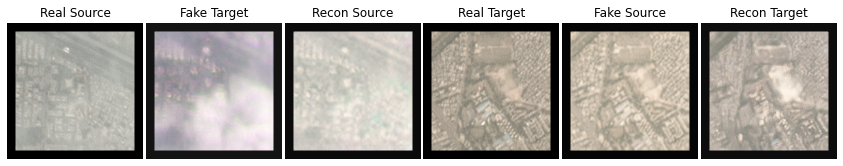

[Epoch 1/100] [Batch 1000/14529]
pm from real source: 148.567	pm from fake target: 133.1217	 pm label source: 97.0
pm from real target: 112.9307	pm from fake source: 157.8402	 pm label target: 114.71



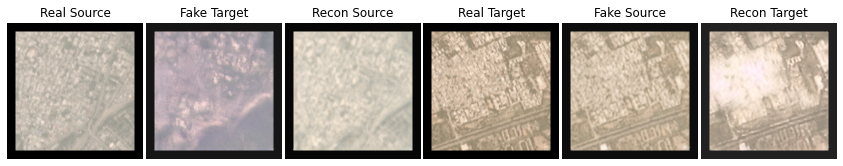

[Epoch 1/100] [Batch 2000/14529]
loss improved on epoch 1: 16.21573829650879
pm from real source: 89.2016	pm from fake target: 101.2037	 pm label source: 19.19
pm from real target: 105.329	pm from fake source: 99.0879	 pm label target: 69.72



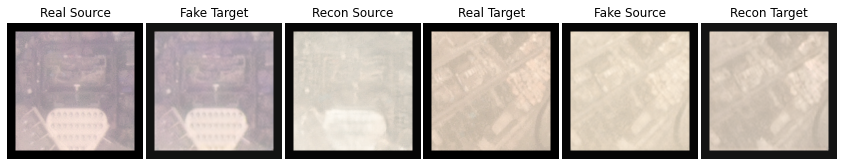

[Epoch 1/100] [Batch 3000/14529]
pm from real source: 87.9363	pm from fake target: 74.6216	 pm label source: 73.44
pm from real target: 103.9642	pm from fake source: 91.1928	 pm label target: 38.53



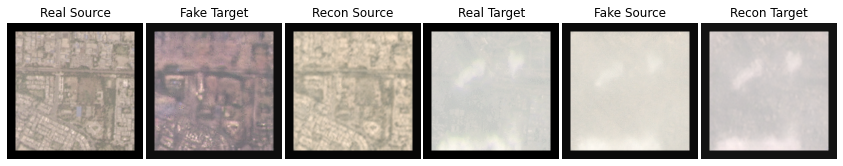

[Epoch 1/100] [Batch 5000/14529]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



pm from real source: 64.106	pm from fake target: 79.0454	 pm label source: 66.24
pm from real target: 78.0363	pm from fake source: 79.3975	 pm label target: 76.5



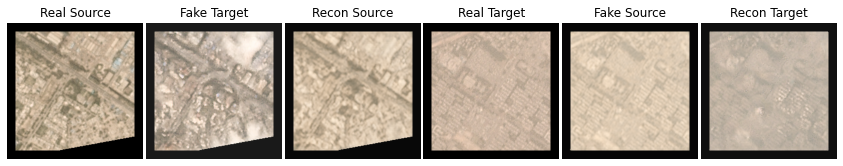

[Epoch 1/100] [Batch 6000/14529]
pm from real source: 113.0387	pm from fake target: 116.2263	 pm label source: 99.2
pm from real target: 108.1802	pm from fake source: 87.2737	 pm label target: 127.24



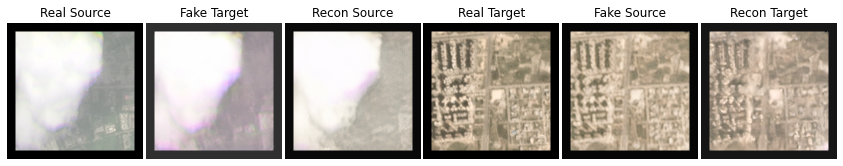

[Epoch 1/100] [Batch 7000/14529]
pm from real source: 77.9139	pm from fake target: 70.2545	 pm label source: 48.27
pm from real target: 81.1178	pm from fake source: 112.7195	 pm label target: 77.06



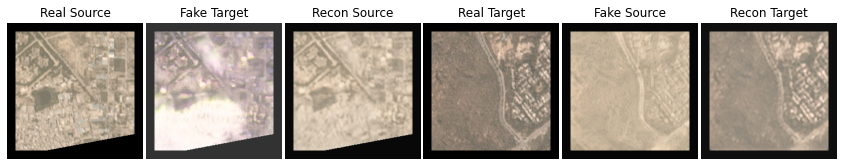

[Epoch 1/100] [Batch 8000/14529]
loss improved on epoch 1: 13.421210289001465
pm from real source: 140.9936	pm from fake target: 116.334	 pm label source: 68.4
pm from real target: 151.8332	pm from fake source: 156.1024	 pm label target: 219.0



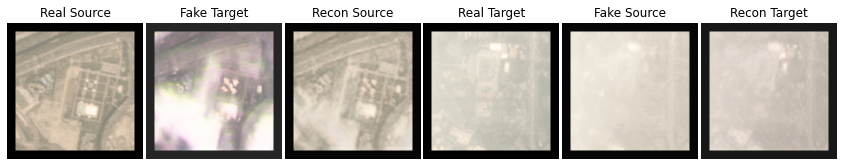

[Epoch 1/100] [Batch 9000/14529]
pm from real source: 85.1363	pm from fake target: 75.6307	 pm label source: 205.91
pm from real target: 72.2558	pm from fake source: 72.8427	 pm label target: 32.9



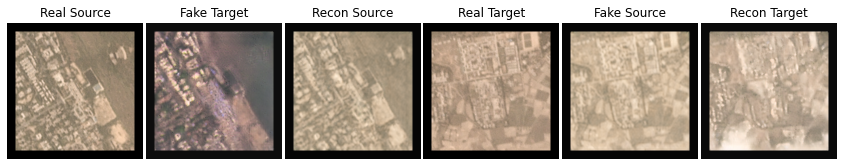

[Epoch 1/100] [Batch 10000/14529]
pm from real source: 51.652	pm from fake target: 81.2039	 pm label source: 25.86
pm from real target: 76.6526	pm from fake source: 70.1264	 pm label target: 84.31



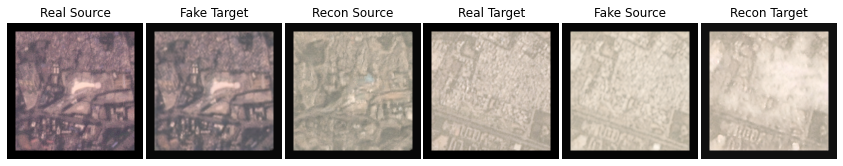

[Epoch 1/100] [Batch 11000/14529]


In [ ]:
history = {'epoch':[],'G_loss':[],'adv_loss': [],'cyc_loss': [], 'idt_loss': [], 'D_loss':[], 'batch':[]}
best_D_loss = 1e6
best_G_loss = 1e6
best_sem_loss = 1e7
pm_saver = {'epoch':[],'predict_from_source':[], "predict_from_target":[], "predict_from_fake_targ":[], "predict_from_fake_source":[], "pm_source_label":[], "pm_target_label":[], "predict_recon_source":[], "predict_recon_targ":[]}
epoch = 0 
n_epochs = 100

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        # Set model input
        real_A = batch['source img'].type(Tensor)
        real_B = batch['target img'].type(Tensor)
        lbl_A = batch['source pm'].type(Tensor)
        lbl_B = batch['target pm'].type(Tensor)
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        #maybe try separate instances of C_A
        pm_from_real_source = C_A(real_A).squeeze(1)
        pm_from_real_target = C_A(real_B).squeeze(1)
        
        pm_from_fake_target = C_A(fake_B.detach()).squeeze(1)
        pm_from_fake_source = C_A(fake_A.detach()).squeeze(1)
        
        pm_from_recon_source = C_A(recov_A.detach()).squeeze(1)
        pm_from_recon_target = C_A(recov_B.detach()).squeeze(1)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) 
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape)))

        
# -----------------
# Train C_A  ;;No backwards run in phase 3;;
# -----------------
        optimizer_C_A.zero_grad()
        C_A.train()
        
        loss_sem1 = criterion_PM(pm_from_real_source, lbl_A)
        loss_sem2 = criterion_PM(pm_from_fake_target, lbl_A)
        loss_sem3 = criterion_PM(pm_from_recon_source, lbl_A)
        
        loss_sem4 = criterion_PM(pm_from_real_target, lbl_B)
        loss_sem5 = criterion_PM(pm_from_fake_source, lbl_B)
        loss_sem6 = criterion_PM(pm_from_recon_target, lbl_B)

        
        loss_semS = (loss_sem1 +loss_sem2 + loss_sem3)/3
        loss_semT = (loss_sem4 + loss_sem5 + loss_sem6)/3
        loss_sem = (loss_semS + loss_semT)/2
        
        loss_sem.backward()
        optimizer_C_A.step()

        if epoch == 99:
            pm_saver['epoch'].append(epoch+1)
            pm_saver['predict_from_source'].append(pm_from_real_source.item())
            pm_saver['predict_from_target'].append(pm_from_real_target.item())
            pm_saver['predict_from_fake_targ'].append(pm_from_fake_target.item())
            pm_saver['predict_from_fake_source'].append(pm_from_fake_source.item())
            pm_saver['pm_source_label'].append(lbl_A.item())
            pm_saver['pm_target_label'].append(lbl_B.item())
            pm_saver['predict_recon_source'].append(pm_from_recon_source.item())
            pm_saver['predict_recon_targ'].append(pm_from_recon_target.item())


# -----------------
# Train Generators ;;No backwards run in phase 3;;
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        

# ------> Total Loss
        loss_G = loss_GAN + (15.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        # Semantic Loss
        if (i+1) % 1000 ==0:
            print(f'pm from real source: {round(pm_from_real_source.item(),4)}\tpm from fake target: {round(pm_from_fake_target.item(),4)}\t pm label source: {round(lbl_A.item(),2)}')
            print(f'pm from real target: {round(pm_from_real_target.item(),4)}\tpm from fake source: {round(pm_from_fake_source.item(),4)}\t pm label target: {round(lbl_B.item(),2)}\n')
        loss_sem_AB = criterion_PM(pm_from_fake_target, lbl_A)
        loss_sem_BA = criterion_PM(pm_from_fake_source, pm_from_real_target)
        
        loss_G += loss_sem_AB + loss_sem_BA
        
#         loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------
# Train Discriminator A and Discriminator B ;;No backwards run in phase 3;;
# -------------------------------------------
        optimizer_D.zero_grad()
        D_A.train()
        D_B.train()
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        loss_D_A = (loss_real + loss_fake)/2
#         loss_D_A.backward()

        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        loss_D_B = (loss_real + loss_fake)/2
#         loss_D_B.backward()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
        optimizer_D.step()
        


# -----------------
# Model Saving
# -----------------    
            
        if loss_sem <= best_sem_loss:
            print(f'loss improved on epoch {epoch+1}: {loss_sem.item()}')
            best_sem_loss = loss_sem
            torch.save({'C_A': C_A.state_dict()}, 'pm.pt')
        
        
# -----------------
# Show Progress
# -----------------

        if (i+1) % 1000 == 0:
            with torch.no_grad():
#                 sample_images('Delhi', 'Lucknow',dataloader, epoch, i, show = False, save = False)
                sample_images('Delhi/Lucknow', 'Mumbai', val_dataloader, epoch, i, show = True, save = True)

                print('[Epoch %d/%d] [Batch %d/%d]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                     ))
            
            history['G_loss'].append(loss_G.item())
            history['D_loss'].append(loss_D.item())
            history['batch'].append(i+1)
            history['epoch'].append(epoch+1)
            history['adv_loss'].append(loss_GAN.item())
            history['cyc_loss'].append(loss_cycle.item())
            history['idt_loss'].append(loss_identity.item())
            


In [ ]:
pms = pd.DataFrame(pm_saver)
pms.to_csv('predicted_pms_w_T.csv', index=False)

In [ ]:
df = pd.DataFrame(history)
df.to_csv('history_w_T.csv', index=False)

In [ ]:
sem_model_check = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/pm.pt')
C_B = Multi_City_CNN()
C_B.load_state_dict(sem_model_check['C_A'])
C_B.to(device)

In [11]:
test_pm = {'predict_from_source':[], "predict_from_target":[], "predict_from_fake_targ":[], "predict_from_fake_source":[], "pm_source_label":[], "pm_target_label":[], "predict_recon_source":[], "predict_recon_targ":[]}

with torch.no_grad():
    for i, batch in enumerate(tqdm(testloader)):
        real_A = batch['tr_img'].type(Tensor)
        real_B = batch['te_img'].type(Tensor)
        lbl_A = batch['tr_pm'].type(Tensor)
        lbl_B = batch['te_pm'].type(Tensor)

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)

        #maybe try separate instances of C_A
        pm_from_real_source = C_A(real_A).squeeze(1)
        pm_from_real_target = C_A(real_B).squeeze(1)

        pm_from_fake_target = C_A(fake_B.detach()).squeeze(1)
        pm_from_fake_source = C_A(fake_A.detach()).squeeze(1)

        pm_from_recon_source = C_A(recov_A.detach()).squeeze(1)
        pm_from_recon_target = C_A(recov_B.detach()).squeeze(1)
        
        
#         loss_sem1 = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem2 = criterion_PM(pm_from_fake_target, lbl_A)
#         loss_sem3 = criterion_PM(pm_from_recon_source, lbl_A)
        
#         loss_sem4 = criterion_PM(pm_from_real_target, lbl_B)
#         loss_sem5 = criterion_PM(pm_from_fake_source, lbl_B)
#         loss_sem6 = criterion_PM(pm_from_recon_target, lbl_B)

        test_pm['predict_from_source'].append(pm_from_real_source.item())
        test_pm['predict_from_target'].append(pm_from_real_target.item())
        test_pm['predict_from_fake_targ'].append(pm_from_fake_target.item())
        test_pm['predict_from_fake_source'].append(pm_from_fake_source.item())
        test_pm['pm_source_label'].append(lbl_A.item())
        test_pm['pm_target_label'].append(lbl_B.item())
        test_pm['predict_recon_source'].append(pm_from_recon_source.item())
        test_pm['predict_recon_targ'].append(pm_from_recon_target.item())

#                 sample_images('Delhi', 'Lucknow',dataloader, epoch, i, show = False, save = False)
#     sample_images('Delhi/Lucknow', 'Mumbai', testloader, epoch, i, show = True, save = False)


In [ ]:
pms = pd.DataFrame(test_pm)
pms.to_csv('test_pms.csv', index=False)

In [12]:
df = pd.DataFrame(test_pm)
source_prediction= df['predict_from_target'].tolist()
source_label = df['pm_target_label'].tolist()

In [2]:
df = pd.read_csv('/datacommons/carlsonlab/srs108/cycle/phase_two/predicted_pms_w_T.csv')

In [13]:
df

,predict_from_source,predict_from_target,predict_from_fake_targ,predict_from_fake_source,pm_source_label,pm_target_label,predict_recon_source,predict_recon_targ
0,90.044250,88.681473,85.868965,82.610626,266.920013,110.870003,81.787933,75.656837
1,84.757759,87.214851,83.624756,89.472397,69.199997,25.240000,78.898750,83.189293
2,86.137329,84.294441,86.743843,79.489998,93.669998,101.809998,79.596092,89.147652
3,83.300102,79.434135,81.110344,79.262062,104.900002,19.379999,90.755463,86.227684
4,85.277191,88.193634,87.282845,83.974236,231.679993,46.950001,87.176247,87.812767
...,...,...,...,...,...,...,...,...
1995,89.276970,90.084343,83.224640,85.292351,46.689999,37.919998,87.348122,89.214256
1996,87.950577,90.787628,90.063148,76.512947,63.580002,55.240002,78.348846,86.607048
1997,86.374634,76.799438,90.486832,78.915230,50.150002,9.850000,87.840370,87.847084
1998,86.015846,89.629051,89.615295,86.544243,72.529999,27.629999,86.993385,90.830086


In [22]:
# Select only the two columns for which you want to compute the row-wise average
selected_columns = ['predict_from_target', 'predict_recon_targ']

# Compute the row-wise mean using only the selected columns
row_mean_selected = df[selected_columns].mean(axis=1)

# Add the row-wise mean as a new column to the DataFrame
df['avg_pred_targ_recon'] = row_mean_selected



In [14]:
source_prediction= df['predict_recon_targ'].tolist()
source_label = df['pm_target_label'].tolist()

In [15]:
from scipy import stats
from sklearn import metrics

def eval_stat(predictions, ground_truth):
    Rsquared, pvalue = stats.spearmanr(predictions, ground_truth)
    Rsquared_pearson, pvalue_pearson = stats.pearsonr(predictions, ground_truth)
    return Rsquared, pvalue, Rsquared_pearson, pvalue_pearson

def plot_result(predictions, ground_truth, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, lower_bound=0, upper_bound=175,
                save = True, plot_title = '', fig_name = ''):
    plt.rcParams.update({'mathtext.default':  'regular' })
    
    fig, ax = plt.subplots(figsize = (7,7))
    ax.scatter(ground_truth, predictions,color = 'green', alpha=0.5, edgecolors=(0, 0, 0),  s = 100)
    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=1)
    ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 17)
    ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 17)
    ax.set_title(str(plot_title))
    
    ax.tick_params(labelsize = 10)
    fig.text(0.15, 0.85, 'Spearman r = '+ str(np.round(Rsquared,2))) 
    plt.axis('tight')
    fig.text(0.15, 0.81, 'Pearson r = '+ str(np.round(Rsquared_pearson,2)))
    fig.text(0.15, 0.77, 'RMSE = '+ str(np.round(np.sqrt(metrics.mean_squared_error(ground_truth, predictions)),2)))#
 
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    if save:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'_'+'.png', transparent=False, facecolor='white', bbox_inches='tight')
    pass
    return

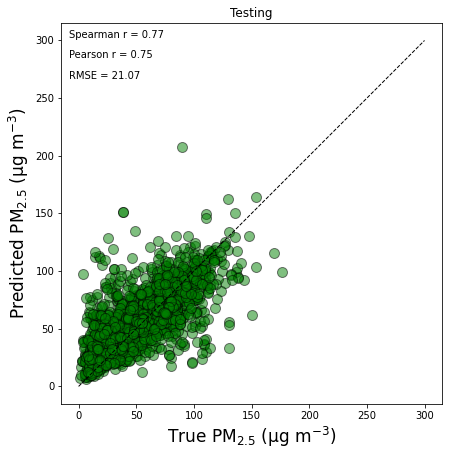

In [25]:
train_predictions_ = source_prediction
train_ground_truth_ = source_label
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(train_predictions_, train_ground_truth_)

plot_result(train_predictions_, train_ground_truth_, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, lower_bound=0, upper_bound=300,save = False , plot_title='Testing', fig_name = 'train')

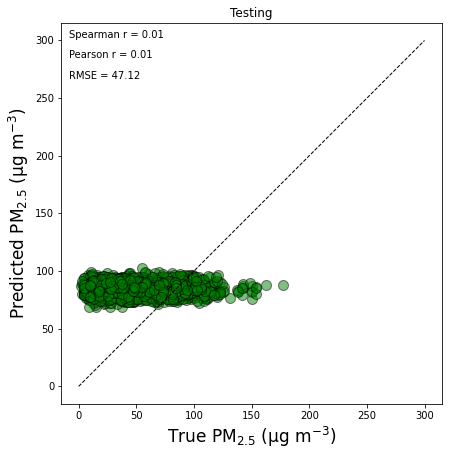

In [16]:
train_predictions_ = source_prediction
train_ground_truth_ = source_label
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(train_predictions_, train_ground_truth_)

plot_result(train_predictions_, train_ground_truth_, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, lower_bound=0, upper_bound=300,save = False , plot_title='Testing', fig_name = 'train')